In [2]:
# =============================================================================
# YOLOÁõÆÊ†áÊ£ÄÊµãÂÆåÊï¥ËÆ≠ÁªÉËÑöÊú¨
# ÈÄÇÁî®‰∫éJupyter NotebookÔºåÊåâÊ≥®ÈáäÂàÜÂùóËøêË°å
# =============================================================================

# Âùó1ÔºöÂØºÂÖ•ÂøÖË¶ÅÁöÑÂ∫ìÂíåËÆæÁΩÆ
# Âùó1ÔºöÂØºÂÖ•ÂøÖË¶ÅÁöÑÂ∫ìÂíåËÆæÁΩÆ
import os
import json
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
from PIL import Image, ImageDraw
import random
from ultralytics import YOLO
import torch
import warnings  # ÂØºÂÖ•Ë≠¶ÂëäÊ®°Âùó

# ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰ΩìÊòæÁ§∫‰∏∫ÂæÆËΩØÈõÖÈªë
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # ‰øÆÊîπ‰∏∫ÂæÆËΩØÈõÖÈªë
plt.rcParams['axes.unicode_minus'] = False

# ÂøΩÁï•Ë≠¶Âëä‰ø°ÊÅØ
warnings.filterwarnings('ignore')  # Ê∑ªÂä†ÂøΩÁï•Ë≠¶ÂëäÁöÑËÆæÁΩÆ

# ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("ÁéØÂ¢ÉËÆæÁΩÆÂÆåÊàêÔºÅ")

Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
ÁéØÂ¢ÉËÆæÁΩÆÂÆåÊàêÔºÅ


In [4]:
# =============================================================================
# Âùó2ÔºöÊï∞ÊçÆÊ†ºÂºèËΩ¨Êç¢ÂáΩÊï∞ÂÆö‰πâ
def json_to_yolo_format(json_path, img_width, img_height, class_mapping):
    """
    Â∞ÜJSONÊ†áÊ≥®ËΩ¨Êç¢‰∏∫YOLOÊ†ºÂºè
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    yolo_annotations = []
    
    # Â§ÑÁêÜÊ†áÊ≥®‰ø°ÊÅØ
    if 'shapes' in data:
        for shape in data['shapes']:
            label = shape['label']
            if label in class_mapping:
                class_id = class_mapping[label]
                points = shape['points']
                
                # ËÆ°ÁÆóËæπÁïåÊ°Ü
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]
                
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                
                # ËΩ¨Êç¢‰∏∫YOLOÊ†ºÂºè (‰∏≠ÂøÉÁÇπÂùêÊ†áÂíåÁõ∏ÂØπÂÆΩÈ´ò)
                x_center = (x_min + x_max) / 2 / img_width
                y_center = (y_min + y_max) / 2 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height
                
                yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    return yolo_annotations

def setup_yolo_dataset(source_dir, output_dir):
    """
    ËÆæÁΩÆYOLOÊï∞ÊçÆÈõÜÊ†ºÂºè
    """
    # ÂàõÂª∫ÁõÆÂΩïÁªìÊûÑ
    dataset_dirs = {
        'train_images': os.path.join(output_dir, 'images', 'train'),
        'val_images': os.path.join(output_dir, 'images', 'val'),
        'train_labels': os.path.join(output_dir, 'labels', 'train'),
        'val_labels': os.path.join(output_dir, 'labels', 'val')
    }
    
    for dir_path in dataset_dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    # Á±ªÂà´Êò†Â∞Ñ
    class_mapping = {
        'ËÅöÈÖØÁîµÂÆπ': 0,
        'ÁÉ≠ÊïèÁîµÈòª': 1, 
        '‰∏âÁ´ØÁ®≥ÂéãÁÆ°': 2
    }
    
    # Ëé∑ÂèñÊâÄÊúâbmpÊñá‰ª∂
    bmp_files = [f for f in os.listdir(source_dir) if f.endswith('.bmp')]
    
    # ÈöèÊú∫ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜ (80:20)
    random.shuffle(bmp_files)
    split_idx = int(len(bmp_files) * 0.8)
    train_files = bmp_files[:split_idx]
    val_files = bmp_files[split_idx:]
    
    def process_files(files, split):
        for bmp_file in files:
            # ÊûÑÂª∫Êñá‰ª∂Ë∑ØÂæÑ
            img_path = os.path.join(source_dir, bmp_file)
            json_file = bmp_file.replace('.bmp', '.bmp.json')
            json_path = os.path.join(source_dir, json_file)
            
            if not os.path.exists(json_path):
                print(f"Ë≠¶Âëä: Êâæ‰∏çÂà∞Ê†áÊ≥®Êñá‰ª∂ {json_file}")
                continue
            
            # ËØªÂèñÂõæÁâáËé∑ÂèñÂ∞∫ÂØ∏
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_height, img_width = img.shape[:2]
            
            # ËΩ¨Êç¢Ê†áÊ≥®Ê†ºÂºè
            yolo_annotations = json_to_yolo_format(json_path, img_width, img_height, class_mapping)
            
            # Â§çÂà∂ÂõæÁâá
            if split == 'train':
                dst_img = os.path.join(dataset_dirs['train_images'], bmp_file)
                dst_label = os.path.join(dataset_dirs['train_labels'], bmp_file.replace('.bmp', '.txt'))
            else:
                dst_img = os.path.join(dataset_dirs['val_images'], bmp_file)
                dst_label = os.path.join(dataset_dirs['val_labels'], bmp_file.replace('.bmp', '.txt'))
            
            shutil.copy2(img_path, dst_img)
            
            # ‰øùÂ≠òÊ†áÊ≥®Êñá‰ª∂
            with open(dst_label, 'w') as f:
                f.write('\n'.join(yolo_annotations))
    
    process_files(train_files, 'train')
    process_files(val_files, 'val')
    
    print(f"Êï∞ÊçÆÈõÜÂàíÂàÜÂÆåÊàê:")
    print(f"ËÆ≠ÁªÉÈõÜ: {len(train_files)} Âº†ÂõæÁâá")
    print(f"È™åËØÅÈõÜ: {len(val_files)} Âº†ÂõæÁâá")
    
    return dataset_dirs, class_mapping

In [5]:
# =============================================================================
# Âùó3ÔºöÊâßË°åÊï∞ÊçÆÊ†ºÂºèËΩ¨Êç¢
source_directory = "/mnt/workspace/data"  # ‰øÆÊîπ‰∏∫ÊÇ®ÁöÑÊï∞ÊçÆÈõÜË∑ØÂæÑ
output_directory = "/mnt/workspace/yolo_data"

# Â¶ÇÊûúÊÇ®ÁöÑÊï∞ÊçÆÂú®ÂΩìÂâçÁõÆÂΩïÔºåÂèØ‰ª•ËøôÊ†∑ËÆæÁΩÆ
# source_directory = "./"  

dataset_dirs, class_mapping = setup_yolo_dataset(source_directory, output_directory)
print("Êï∞ÊçÆÊ†ºÂºèËΩ¨Êç¢ÂÆåÊàêÔºÅ")

[ERROR:0@126.344] global loadsave.cpp:507 imread_ imread_('/mnt/workspace/data/(8).bmp'): can't read data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/bitstrm.cpp:67: error: (-2:Unspecified error) Unexpected end of input stream in function 'readBlock'



Êï∞ÊçÆÈõÜÂàíÂàÜÂÆåÊàê:
ËÆ≠ÁªÉÈõÜ: 50 Âº†ÂõæÁâá
È™åËØÅÈõÜ: 13 Âº†ÂõæÁâá
Êï∞ÊçÆÊ†ºÂºèËΩ¨Êç¢ÂÆåÊàêÔºÅ


In [9]:
# =============================================================================
# Âùó4ÔºöÂàõÂª∫YOLOÈÖçÁΩÆÊñá‰ª∂
def create_yaml_config(output_dir, class_mapping):
    """
    ÂàõÂª∫YOLOËÆ≠ÁªÉÈÖçÁΩÆÊñá‰ª∂
    """
    config = {
        'path': os.path.abspath(output_dir),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_mapping),
        'names': {v: k for k, v in class_mapping.items()}
    }
    
    yaml_path = os.path.join(output_dir, 'dataset.yaml')
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.dump(config, f, default_flow_style=False, allow_unicode=True)
    
    return yaml_path

yaml_config_path = create_yaml_config(output_directory, class_mapping)
print(f"ÈÖçÁΩÆÊñá‰ª∂Â∑≤ÂàõÂª∫: {yaml_config_path}")

ÈÖçÁΩÆÊñá‰ª∂Â∑≤ÂàõÂª∫: /mnt/workspace/yolo_data/dataset.yaml


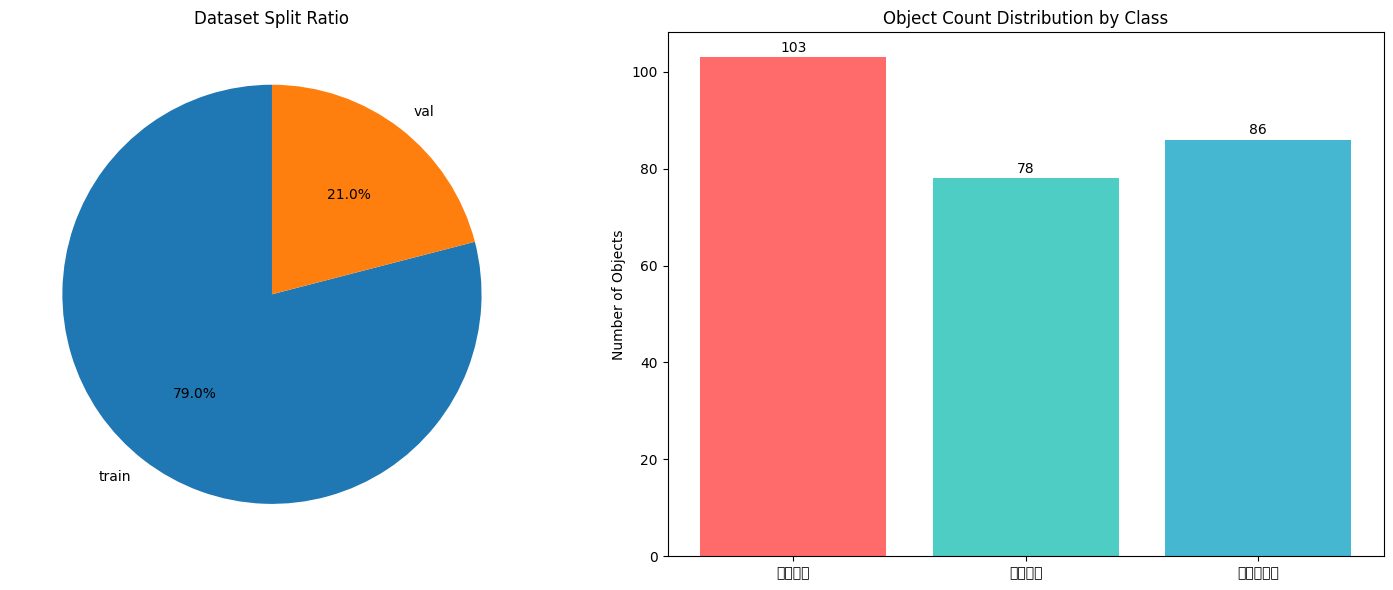

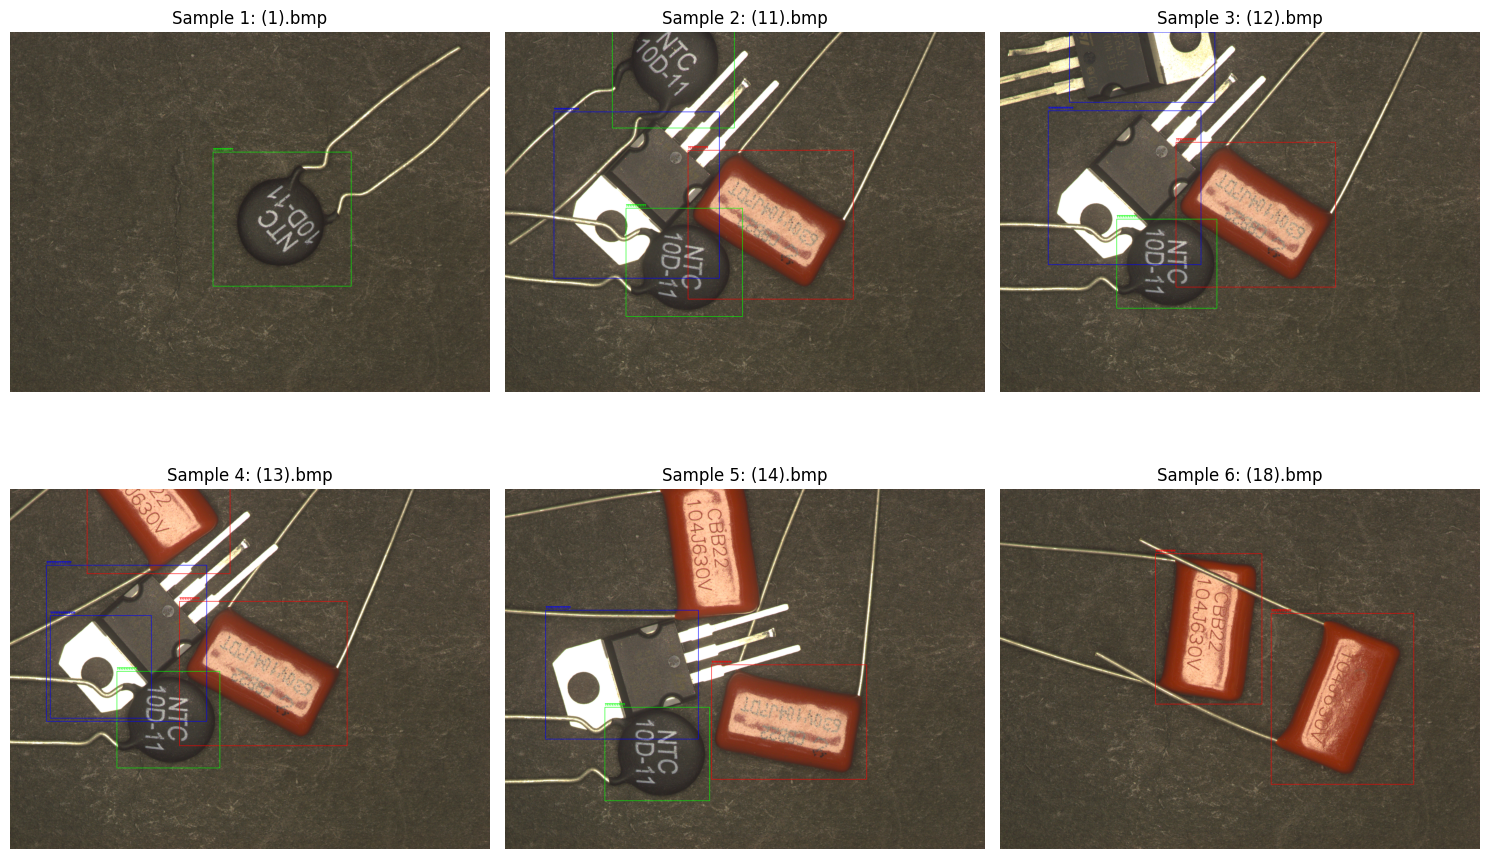

In [6]:
# =============================================================================
# Block 5: Data Visualization Functions
def visualize_dataset_statistics(dataset_dirs, class_mapping):
    """
    Visualize dataset statistical information
    """
    # Count the number of objects in each class
    class_counts = {name: 0 for name in class_mapping.keys()}
    image_counts = {'train': 0, 'val': 0}
    
    for split in ['train', 'val']:
        label_dir = dataset_dirs[f'{split}_labels']
        image_counts[split] = len(os.listdir(dataset_dirs[f'{split}_images']))
        
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(label_dir, label_file)
                with open(label_path, 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = int(line.split()[0])
                            class_name = list(class_mapping.keys())[class_id]
                            class_counts[class_name] += 1
    
    # Create visualization charts
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Figure 1: Dataset split
    splits = list(image_counts.keys())
    counts = list(image_counts.values())
    axes[0].pie(counts, labels=splits, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Dataset Split Ratio')
    
    # Figure 2: Class distribution
    classes = list(class_counts.keys())
    class_nums = list(class_counts.values())
    bars = axes[1].bar(classes, class_nums, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1].set_title('Object Count Distribution by Class')
    axes[1].set_ylabel('Number of Objects')
    
    # Add values on bar chart
    for bar, count in zip(bars, class_nums):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return class_counts, image_counts

def visualize_sample_images(dataset_dirs, class_mapping, num_samples=6):
    """
    Visualize sample images and annotations
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    train_img_dir = dataset_dirs['train_images']
    train_label_dir = dataset_dirs['train_labels']
    
    img_files = os.listdir(train_img_dir)[:num_samples]
    
    class_colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)}  # RGB
    class_names = {v: k for k, v in class_mapping.items()}
    
    for idx, img_file in enumerate(img_files):
        if idx >= num_samples:
            break
            
        # Read image
        img_path = os.path.join(train_img_dir, img_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read annotations
        label_file = img_file.replace('.bmp', '.txt')
        label_path = os.path.join(train_label_dir, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])
                        
                        # Convert to pixel coordinates
                        img_h, img_w = img.shape[:2]
                        x_center *= img_w
                        y_center *= img_h
                        width *= img_w
                        height *= img_h
                        
                        x1 = int(x_center - width/2)
                        y1 = int(y_center - height/2)
                        x2 = int(x_center + width/2)
                        y2 = int(y_center + height/2)
                        
                        # Draw bounding box
                        color = class_colors[class_id]
                        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(img_rgb, class_names[class_id], (x1, y1-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f'Sample {idx+1}: {img_file}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Execute data visualization
class_counts, image_counts = visualize_dataset_statistics(dataset_dirs, class_mapping)
visualize_sample_images(dataset_dirs, class_mapping)

In [7]:
# =============================================================================
# Âùó6ÔºöÊï∞ÊçÆÂ¢ûÂº∫ÈÖçÁΩÆ
def setup_data_augmentation():
    """
    ËÆæÁΩÆÊï∞ÊçÆÂ¢ûÂº∫ÂèÇÊï∞
    """
    augmentation_config = {
        'hsv_h': 0.015,      # Ëâ≤Ë∞ÉÂèòÂåñ
        'hsv_s': 0.7,        # È•±ÂíåÂ∫¶ÂèòÂåñ
        'hsv_v': 0.4,        # ÊòéÂ∫¶ÂèòÂåñ
        'degrees': 10.0,      # ÊóãËΩ¨ËßíÂ∫¶
        'translate': 0.1,     # Âπ≥Áßª
        'scale': 0.5,        # Áº©Êîæ
        'shear': 0.0,        # Ââ™Âàá
        'perspective': 0.0,   # ÈÄèËßÜÂèòÊç¢
        'flipud': 0.0,       # ‰∏ä‰∏ãÁøªËΩ¨
        'fliplr': 0.5,       # Â∑¶Âè≥ÁøªËΩ¨
        'mosaic': 1.0,       # È©¨ËµõÂÖãÂ¢ûÂº∫
        'mixup': 0.0,        # Ê∑∑ÂêàÂ¢ûÂº∫
        'copy_paste': 0.0    # Â§çÂà∂Á≤òË¥¥Â¢ûÂº∫
    }
    
    return augmentation_config

augmentation_params = setup_data_augmentation()
print("Êï∞ÊçÆÂ¢ûÂº∫ÂèÇÊï∞ÈÖçÁΩÆÂÆåÊàê")

Êï∞ÊçÆÂ¢ûÂº∫ÂèÇÊï∞ÈÖçÁΩÆÂÆåÊàê


In [11]:
# =============================================================================
# Âùó7ÔºöÊ®°ÂûãËÆ≠ÁªÉ
def train_yolo_model(yaml_path, epochs=20, batch_size=8, img_size=640):
    """
    ËÆ≠ÁªÉYOLOÊ®°Âûã
    """
    # Âä†ËΩΩÈ¢ÑËÆ≠ÁªÉÊ®°Âûã
    model = YOLO('./yolo11n.pt')  # ‰ºöËá™Âä®‰∏ãËΩΩÈ¢ÑËÆ≠ÁªÉÊùÉÈáç
    
    # ËÆ≠ÁªÉÈÖçÁΩÆ
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        patience=20,
        save=True,
        device=0,  # Ëá™Âä®ÈÄâÊã©GPUÊàñCPU
        **augmentation_params
    )
    
    return model, results

print("ÂºÄÂßãËÆ≠ÁªÉÊ®°Âûã...")
model, training_results = train_yolo_model(yaml_config_path, epochs=50, batch_size=8)
print("Ê®°ÂûãËÆ≠ÁªÉÂÆåÊàêÔºÅ")

ÂºÄÂßãËÆ≠ÁªÉÊ®°Âûã...
Ultralytics 8.3.162 üöÄ Python-3.11.11 torch-2.3.1+cu121 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: gpu
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [12]:
import torch
print("=== CUDA ËØäÊñ≠‰ø°ÊÅØ ===")
print(f"PyTorchÁâàÊú¨: {torch.__version__}")
print(f"CUDAÊòØÂê¶ÂèØÁî®: {torch.cuda.is_available()}")
print(f"CUDAËÆæÂ§áÊï∞Èáè: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"ÂΩìÂâçCUDAËÆæÂ§á: {torch.cuda.current_device()}")
    print(f"CUDAËÆæÂ§áÂêçÁß∞: {torch.cuda.get_device_name()}")
else:
    print("CUDA‰∏çÂèØÁî®ÔºåÂ∞Ü‰ΩøÁî®CPUËÆ≠ÁªÉ")

# Ê£ÄÊü•ÁéØÂ¢ÉÂèòÈáè
import os
cuda_visible = os.environ.get('CUDA_VISIBLE_DEVICES', 'Êú™ËÆæÁΩÆ')
print(f"CUDA_VISIBLE_DEVICES: {cuda_visible}")

=== CUDA ËØäÊñ≠‰ø°ÊÅØ ===
PyTorchÁâàÊú¨: 2.3.1+cu121
CUDAÊòØÂê¶ÂèØÁî®: False
CUDAËÆæÂ§áÊï∞Èáè: 0
CUDA‰∏çÂèØÁî®ÔºåÂ∞Ü‰ΩøÁî®CPUËÆ≠ÁªÉ
CUDA_VISIBLE_DEVICES: 0
